In [2]:
import numpy as np
import cupy as cp
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
import qiskit
from cuquantum import *
import time

### Get dataset

In [3]:
traindata = pd.read_csv('../Data/fashion-mnist-data/fashion-mnist_train.csv')

In [4]:
def data_per_class(label,ds_train,ds_test):
    filt = (traindata['label'] == label)
    one_class_train = traindata.loc[filt][:ds_train]
    one_class_test  = traindata.loc[filt][ds_train:ds_train+ds_test]
    return one_class_train, one_class_test

In [5]:
# data_per_class function check
num_train = 500
num_test  = 50
data_0_train, data_0_test = data_per_class(0,num_train,num_test)
data_0_train.shape, data_0_test.shape

((500, 785), (50, 785))

In [6]:
def fashion_data(data0,data1,n_dim):
    full_class = pd.concat([data0,data1]).sample(frac = 1)
    data_full  = full_class.iloc[:,1:785] / 255.0
    data_full  = StandardScaler().fit_transform(data_full)
    pca        = PCA(n_components=n_dim).fit(data_full)
    data_full  = pca.transform(data_full)   
    label_full = pd.DataFrame([full_class.iloc[:,0]]).T
    label_full = np.array(label_full).ravel()
    return data_full,label_full

In [7]:
# fashion_data function check
n_dim = 2
num_train = 500
num_test  = 50
class_lb = [0,1] 

data_0_train, data_0_test = data_per_class(class_lb[0],num_train,num_test)
data_1_train, data_1_test = data_per_class(class_lb[1],num_train,num_test)

In [8]:
# check train data
data_train, label_train = fashion_data(data_0_train,data_1_train,n_dim)
unique, counts = np.unique(label_train, return_counts=True)
print(unique, counts)
print(data_train.shape)
label_train[:50]

[0 1] [500 500]
(1000, 2)


array([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1])

In [9]:
# check test data
data_test, label_test = fashion_data(data_0_test,data_1_test,n_dim)
unique, counts = np.unique(label_test, return_counts=True)
print(unique, counts)
print(data_test.shape)
label_test[:50]

[0 1] [50 50]
(100, 2)


array([0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1])

---

### Get quantum circuit

In [10]:
import os
from itertools import combinations
from multiprocessing import Pool

In [11]:
print(os.cpu_count())

12


In [12]:
def get_qc_circuit(x_t1, x_t2, n_dim):
    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=1, entanglement="linear", insert_barriers=True)
    zz_kernel = QuantumKernel(feature_map=zz_map)  
    zz_circuit = zz_kernel.construct_circuit(x_t1,x_t2,measurement=False,is_statevector_sim=False)
    return zz_circuit

[-7.00122695 -3.99144848] [-7.00122695 -3.99144848]


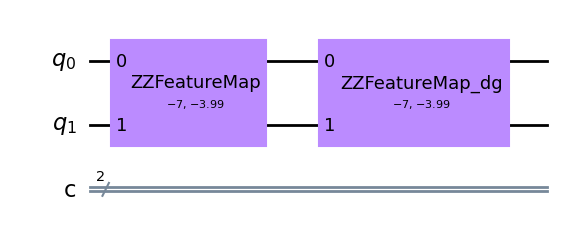

In [13]:
# get_qc_circuit function check
n_dim = 2
num_train = 20
num_test  = 2
class_lb = [0,1] 

data_0_train, data_0_test = data_per_class(class_lb[0],num_train,num_test)
data_1_train, data_1_test = data_per_class(class_lb[1],num_train,num_test)
data_train, label_train   = fashion_data(data_0_train,data_1_train,n_dim)

qsvm_qc = get_qc_circuit(data_train[0],data_train[0],n_dim)
print(data_train[0],data_train[0])
qsvm_qc.decompose().draw('mpl')

- for all qc

In [14]:
def all_circuits(datasize, x_t, n_dim):
    t0 = time.time()
    
    circuits = []
    for i1, i2 in combinations(range(1, datasize + 1), 2):
        cir = get_qc_circuit(x_t[i1-1], x_t[i2-1], n_dim)
        circuits.append(cir)
    print("Time =", time.time()-t0)
    return circuits

In [15]:
# all_circuits function check 
circuits = all_circuits(num_train*2, data_train, n_dim)
print(np.sum(np.arange(1,40)))
len(circuits)

Time = 4.631723165512085
780


780

In [17]:
def all_circuits_parallel(datasize, x_t, n_dim, num_cpu = 12):
    t0 = time.time()

    # Use Pool to parallelize the computation of circuits
    with Pool(processes=num_cpu-2, maxtasksperchild=100) as pool:
        indices_list = list(combinations(range(1, datasize + 1), 2))
        circuits = pool.starmap(get_qc_circuit, [(x_t[i1-1], x_t[i2-1], n_dim) for i1, i2 in indices_list])
    print("Time =", time.time() - t0)
    return circuits

In [18]:
# all_circuits_parallel function check 
circuits_p = all_circuits_parallel(num_train*2, data_train, n_dim)
print(np.sum(np.arange(1,40)))
len(circuits_p)

Time = 1.644298791885376
780


780

---

### Get all operands

In [19]:
def get_path(circuit):
    converter = CircuitToEinsum(circuit, backend='numpy')
    a = str(0).zfill(n_dim)
    exp, oper = converter.amplitude(a)  
    return exp, oper

In [27]:
circuits = all_circuits(num_train*2, data_train, n_dim)
_, oper = get_path(circuits[0])

Time = 4.108287334442139


In [30]:
def all_operands(all_circuits,datasize):
    t0 = time.time()
    
    operands = []
    i = -1
    for i1 in range(2,datasize+1):
        for i2 in range(1,i1):
            i += 1
            _, oper = get_path(all_circuits[i])
            oper_gpu = [cp.asarray(tensor) for tensor in oper]
            operands.append(oper_gpu)
    print("Time =", time.time()-t0)
    
    return operands

In [42]:
# check all_operands with all_circuits
print('all_circuits + all_operands')
circuits = all_circuits(num_train*2, data_train, n_dim)
operands = all_operands(circuits,num_train*2)

all_circuits + all_operands
Time = 4.372447967529297
Time = 7.375977277755737


In [64]:
# check all_operands with all_circuits_p
print('all_circuits_parallel + all_operands')
circuits_p = all_circuits_parallel(num_train*2, data_train, n_dim)
operands = all_operands(circuits_p,num_train*2)

all_circuits_parallel + all_operands
Time = 2.3623592853546143
Time = 6.4214558601379395


In [38]:
def all_operands_parallel(all_circuits,num_cpu = 12):
    t0 = time.time()

    # Use Pool to parallelize the computation of operands
    with Pool(processes=num_cpu-2, maxtasksperchild=100) as pool:
        results = pool.map(get_path, all_circuits)

    operands = [[cp.asarray(tensor) for tensor in oper] for _, oper in results]
    print("Time =", time.time() - t0)

    return operands

In [44]:
# check all_operands_p with all_circuits
print('all_circuits + all_operands_parallel')
circuits = all_circuits(num_train*2, data_train, n_dim)
operands_p = all_operands_parallel(circuits,num_train*2)

all_circuits + all_operands_parallel
Time = 5.730175971984863
Time = 3.7453508377075195


In [65]:
# check all_operands_p with all_circuits_p
print('all_circuits_parallel + all_operands_parallel')
circuits_p = all_circuits_parallel(num_train*2, data_train, n_dim)
operands_p = all_operands_parallel(circuits_p,num_train*2)

all_circuits_parallel + all_operands_parallel
Time = 2.580517053604126
Time = 3.6764023303985596


---

### Get kernel matrix

In [57]:
from sklearn.svm import SVC

In [47]:
def get_kernel_matrix_gpu(operands,x_t,datasize,n_dim):
    kernel_matrix = cp.zeros((datasize,datasize))

    circuit = get_qc_circuit(x_t[0], x_t[0], n_dim)
    exp, _ = get_path(circuit)
    oper, i = operands[0], -1
    with Network(exp, *oper) as tn:
        path, info = tn.contract_path()
        t0 = time.time()
        for i1 in range(2,datasize+1):
            for i2 in range(1,i1):
                i += 1
                tn.reset_operands(*operands[i])
                amp = tn.contract()
                kernel_matrix[i1-1][i2-1] = cp.round(cp.sqrt(cp.square(amp.real)+cp.square(amp.imag)),5)
        kernel_matrix = kernel_matrix + kernel_matrix.T+cp.diag(cp.ones((datasize)))
        print("Time = ", time.time()-t0)
    
    return kernel_matrix

In [66]:
# for train
circuits_p = all_circuits_parallel(num_train*2, data_train, n_dim)
operands_p = all_operands_parallel(circuits_p,num_train*2)
kernel_matrix_train = get_kernel_matrix_gpu(operands_p, data_train, num_train*2, n_dim)

Time = 2.459721088409424
Time = 4.2039079666137695
Time =  1.157463550567627


In [80]:
adhoc_svc = SVC(kernel="precomputed")
adhoc_svc.fit(kernel_matrix_train.get(), label_train)
adhoc_score_precomputed_kernel = adhoc_svc.score(kernel_matrix_train.get(), label_train)
print(f"Precomputed kernel classification train score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification train score: 0.55


---

### full code

In [85]:
import numpy as np
import cupy as cp
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
import qiskit
from cuquantum import *
import time
import os
from itertools import combinations
from multiprocessing import Pool
from sklearn.svm import SVC
print('num of cpu：',os.cpu_count())

num of cpu： 12


In [86]:
traindata = pd.read_csv('../Data/fashion-mnist-data/fashion-mnist_train.csv')

In [101]:
# data
def data_per_class(label,ds_train,ds_test):
    filt = (traindata['label'] == label)
    one_class_train = traindata.loc[filt][:ds_train]
    one_class_test  = traindata.loc[filt][ds_train:ds_train+ds_test]
    return one_class_train, one_class_test
def fashion_data(data0,data1,n_dim):
    full_class = pd.concat([data0,data1]).sample(frac = 1)
    data_full  = full_class.iloc[:,1:785] / 255.0
    data_full  = StandardScaler().fit_transform(data_full)
    pca        = PCA(n_components=n_dim).fit(data_full)
    data_full  = pca.transform(data_full)   
    label_full = pd.DataFrame([full_class.iloc[:,0]]).T
    label_full = np.array(label_full).ravel()
    return data_full,label_full

# quantum circuit
def get_qc_circuit(x_t1, x_t2, n_dim):
    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=1, entanglement="linear", insert_barriers=True)
    zz_kernel = QuantumKernel(feature_map=zz_map)
    zz_circuit = zz_kernel.construct_circuit(x_t1,x_t2,measurement=False,is_statevector_sim=False)   
    return zz_circuit
def all_circuits(datasize, x_t, n_dim):
    t0 = time.time()
    circuits = []
    for i1, i2 in combinations(range(1, datasize + 1), 2):
        cir = get_qc_circuit(x_t[i1-1], x_t[i2-1], n_dim)
        circuits.append(cir)
    print("all_circuits time =", time.time()-t0)
    return circuits
def all_circuits_parallel(datasize, x_t, n_dim, num_cpu):
    t0 = time.time()
    # Use Pool to parallelize the computation of circuits
    with Pool(processes=num_cpu-2, maxtasksperchild=100) as pool:
        indices_list = list(combinations(range(1, datasize + 1), 2))
        circuits = pool.starmap(get_qc_circuit, [(x_t[i1-1], x_t[i2-1], n_dim) for i1, i2 in indices_list])
    print("all_circuits parallel time =", time.time() - t0)
    return circuits

# operands
def get_path(circuit):
    converter = CircuitToEinsum(circuit, backend='numpy')
    a = str(0).zfill(n_dim)
    exp, oper = converter.amplitude(a)  
    return exp, oper
def all_operands(all_circuits,datasize):
    t0 = time.time()
    operands = []
    i = -1
    for i1 in range(2,datasize+1):
        for i2 in range(1,i1):
            i += 1
            _, oper = get_path(all_circuits[i])
            oper_gpu = [cp.asarray(tensor) for tensor in oper]
            operands.append(oper_gpu)
    print("all_operands time =", time.time()-t0)
    return operands
def all_operands_parallel(all_circuits,num_cpu):
    t0 = time.time()
    # Use Pool to parallelize the computation of operands
    with Pool(processes=num_cpu-2, maxtasksperchild=100) as pool:
        results = pool.map(get_path, all_circuits)

    operands = [[cp.asarray(tensor) for tensor in oper] for _, oper in results]
    print("all_operands parallel time =", time.time() - t0)
    return operands

# kernel_matrix
def get_kernel_matrix_gpu(operands,x_t,datasize,n_dim):
    kernel_matrix = cp.zeros((datasize,datasize))
    circuit = get_qc_circuit(x_t[0], x_t[0], n_dim)
    exp, _ = get_path(circuit)
    oper, i = operands[0], -1
    with Network(exp, *oper) as tn:
        path, info = tn.contract_path()
        t0 = time.time()
        for i1 in range(2,datasize+1):
            for i2 in range(1,i1):
                i += 1
                tn.reset_operands(*operands[i])
                amp = tn.contract()
                kernel_matrix[i1-1][i2-1] = cp.round(cp.sqrt(cp.square(amp.real)+cp.square(amp.imag)),5)
        kernel_matrix = kernel_matrix + kernel_matrix.T+cp.diag(cp.ones((datasize)))
        print("get_kernel_matrix time = ", time.time()-t0)
    return kernel_matrix

In [102]:
# normal code
print('normal code')
num_cpu = None
num_train = 20
num_test  = 2
class_lb = [0,1]
n_dim = 2

data_0_train, data_0_test = data_per_class(class_lb[0],num_train,num_test)
data_1_train, data_1_test = data_per_class(class_lb[1],num_train,num_test)
data_train, label_train   = fashion_data(data_0_train,data_1_train,n_dim)
circuits = all_circuits(num_train*2,data_train,n_dim)
operands = all_operands(circuits,num_train*2)
kernel_matrix_train = get_kernel_matrix_gpu(operands,data_train,num_train*2,n_dim)
adhoc_svc = SVC(kernel="precomputed")
adhoc_svc.fit(kernel_matrix_train.get(),label_train)
adhoc_score_precomputed_kernel = adhoc_svc.score(kernel_matrix_train.get(),label_train)
print(f"Precomputed kernel classification train score: {adhoc_score_precomputed_kernel}")

normal code
all_circuits time = 4.970102310180664
all_operands time = 6.896878719329834
get_kernel_matrix time =  1.2241313457489014
Precomputed kernel classification train score: 0.625


In [104]:
# acc code
print('acc code')
num_cpu = 12
num_train = 20
num_test  = 2
class_lb = [0,1]
n_dim = 2

data_0_train, data_0_test = data_per_class(class_lb[0],num_train,num_test)
data_1_train, data_1_test = data_per_class(class_lb[1],num_train,num_test)
data_train, label_train   = fashion_data(data_0_train,data_1_train,n_dim)
circuits_p = all_circuits_parallel(num_train*2,data_train,n_dim,num_cpu)
operands_p = all_operands_parallel(circuits_p,num_cpu)
kernel_matrix_train = get_kernel_matrix_gpu(operands_p, data_train, num_train*2, n_dim)
adhoc_svc = SVC(kernel="precomputed")
adhoc_svc.fit(kernel_matrix_train.get(), label_train)
adhoc_score_precomputed_kernel = adhoc_svc.score(kernel_matrix_train.get(), label_train)
print(f"Precomputed kernel classification train score: {adhoc_score_precomputed_kernel}")

acc code
all_circuits parallel time = 2.154114246368408
all_operands parallel time = 2.954716444015503
get_kernel_matrix time =  1.298703908920288
Precomputed kernel classification train score: 0.425


---

### exp1 code

In [105]:
import numpy as np
import cupy as cp
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
import qiskit
from cuquantum import *
import time
import os
from itertools import combinations
from multiprocessing import Pool
from sklearn.svm import SVC
print(os.cpu_count())

12


In [106]:
traindata = pd.read_csv('../Data/fashion-mnist-data/fashion-mnist_train.csv')

In [107]:
# data
def data_per_class(label,ds_train,ds_test):
    filt = (traindata['label'] == label)
    one_class_train = traindata.loc[filt][:ds_train]
    one_class_test  = traindata.loc[filt][ds_train:ds_train+ds_test]
    return one_class_train, one_class_test
def fashion_data(data0,data1,n_dim):
    full_class = pd.concat([data0,data1]).sample(frac = 1)
    data_full  = full_class.iloc[:,1:785] / 255.0
    data_full  = StandardScaler().fit_transform(data_full)
    pca        = PCA(n_components=n_dim).fit(data_full)
    data_full  = pca.transform(data_full)   
    label_full = pd.DataFrame([full_class.iloc[:,0]]).T
    label_full = np.array(label_full).ravel()
    return data_full,label_full

# quantum circuit
def get_qc_circuit(x_t1, x_t2, n_dim):
    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=1, entanglement="linear", insert_barriers=True)
    zz_kernel = QuantumKernel(feature_map=zz_map)
    zz_circuit = zz_kernel.construct_circuit(x_t1,x_t2,measurement=False,is_statevector_sim=False)   
    return zz_circuit
def all_circuits(datasize, x_t, n_dim):
    circuits = []
    for i1, i2 in combinations(range(1, datasize + 1), 2):
        cir = get_qc_circuit(x_t[i1-1], x_t[i2-1], n_dim)
        circuits.append(cir)
    return circuits
def all_circuits_parallel(datasize, x_t, n_dim, num_cpu):
    # Use Pool to parallelize the computation of circuits
    with Pool(processes=num_cpu-2, maxtasksperchild=100) as pool:
        indices_list = list(combinations(range(1, datasize + 1), 2))
        circuits = pool.starmap(get_qc_circuit, [(x_t[i1-1], x_t[i2-1], n_dim) for i1, i2 in indices_list])
    all_circuits_parallel_t = time.time()-t0
    return circuits

# operands
def get_path(circuit):
    converter = CircuitToEinsum(circuit, backend='numpy')
    a = str(0).zfill(n_dim)
    exp, oper = converter.amplitude(a)  
    return exp, oper
def all_operands(all_circuits,datasize):
    operands = []
    i = -1
    for i1 in range(2,datasize+1):
        for i2 in range(1,i1):
            i += 1
            _, oper = get_path(all_circuits[i])
            oper_gpu = [cp.asarray(tensor) for tensor in oper]
            operands.append(oper_gpu)
    return operands
def all_operands_parallel(all_circuits,num_cpu):
    # Use Pool to parallelize the computation of operands
    with Pool(processes=num_cpu-2, maxtasksperchild=100) as pool:
        results = pool.map(get_path, all_circuits)

    operands = [[cp.asarray(tensor) for tensor in oper] for _, oper in results]
    return operands

# kernel_matrix
def get_kernel_matrix_gpu(operands,x_t,datasize,n_dim):
    kernel_matrix = cp.zeros((datasize,datasize))
    circuit = get_qc_circuit(x_t[0], x_t[0], n_dim)
    exp, _ = get_path(circuit)
    oper, i = operands[0], -1
    with Network(exp, *oper) as tn:
        path, info = tn.contract_path()
        for i1 in range(2,datasize+1):
            for i2 in range(1,i1):
                i += 1
                tn.reset_operands(*operands[i])
                amp = tn.contract()
                kernel_matrix[i1-1][i2-1] = cp.round(cp.sqrt(cp.square(amp.real)+cp.square(amp.imag)),5)
        kernel_matrix = kernel_matrix + kernel_matrix.T+cp.diag(cp.ones((datasize)))
    return kernel_matrix


In [115]:
# start
## normal code
print('normal code')
num_cpu = None
num_train = 20
num_test  = 2
class_lb = [0,1]
svc = SVC(kernel="precomputed")
data_0_train, data_0_test = data_per_class(class_lb[0],num_train,num_test)
data_1_train, data_1_test = data_per_class(class_lb[1],num_train,num_test)

runtime_data = pd.DataFrame([['q','score','data_t','circuits_t','operands_t','kernel_matrix_t','total_t']])
runtime_data.to_csv("normal_code.csv", index=False,header=None,mode='a')
for q in range(2,4):
    n_dim=q
    tf = time.time()
    t0 = time.time()
    data_train, label_train = fashion_data(data_0_train,data_1_train,n_dim)
    data_t = time.time()-t0
    t0 = time.time()
    circuits = all_circuits(num_train*2,data_train,n_dim)
    circuits_t = time.time()-t0
    t0 = time.time()
    operands = all_operands(circuits,num_train*2)
    operands_t = time.time()-t0
    t0 = time.time()
    kernel_matrix_train = get_kernel_matrix_gpu(operands,data_train,num_train*2,n_dim)
    kernel_matrix_t = time.time()-t0
    svc.fit(kernel_matrix_train.get(),label_train)
    score = svc.score(kernel_matrix_train.get(),label_train)
    total_t = time.time()-tf
    print([q,score,data_t,circuits_t,operands_t,kernel_matrix_t,total_t])
    runtime_data = pd.DataFrame([[q,score,data_t,circuits_t,operands_t,kernel_matrix_t,total_t]])
    runtime_data.to_csv("normal_code.csv", index=False,header=None,mode='a')
print('done')

normal code
[2, 0.65, 0.05694293975830078, 5.501977920532227, 7.725270748138428, 1.3856117725372314, 14.672897815704346]
[3, 0.5, 0.04974818229675293, 6.22922945022583, 8.36946177482605, 2.3480992317199707, 16.99894094467163]
done


In [116]:
# start
## acc code
print('acc code')
num_cpu = 12
num_train = 20
num_test  = 2
class_lb = [0,1]
svc = SVC(kernel="precomputed")
data_0_train, data_0_test = data_per_class(class_lb[0],num_train,num_test)
data_1_train, data_1_test = data_per_class(class_lb[1],num_train,num_test)

runtime_data = pd.DataFrame([['q','score','data_t','circuits_t','operands_t','kernel_matrix_t','total_t']])
runtime_data.to_csv("acc_code.csv", index=False,header=None,mode='a')
for q in range(2,4):
    n_dim=q
    tf = time.time()
    t0 = time.time()
    data_train, label_train = fashion_data(data_0_train,data_1_train,n_dim)
    data_t = time.time()-t0
    t0 = time.time()
    circuits_p = all_circuits_parallel(num_train*2,data_train,n_dim,num_cpu)
    circuits_t = time.time()-t0
    t0 = time.time()
    operands_p = all_operands_parallel(circuits_p,num_cpu)
    operands_t = time.time()-t0
    t0 = time.time()
    kernel_matrix_train = get_kernel_matrix_gpu(operands_p,data_train,num_train*2,n_dim)
    kernel_matrix_t = time.time()-t0
    svc.fit(kernel_matrix_train.get(),label_train)
    score = svc.score(kernel_matrix_train.get(),label_train)
    total_t = time.time()-tf
    print([q,score,data_t,circuits_t,operands_t,kernel_matrix_t,total_t])
    runtime_data = pd.DataFrame([[q,score,data_t,circuits_t,operands_t,kernel_matrix_t,total_t]])
    runtime_data.to_csv("acc_code.csv", index=False,header=None,mode='a')
print('done')

acc code
[2, 0.55, 0.026978015899658203, 2.531381130218506, 3.1913678646087646, 1.1622629165649414, 6.915395021438599]
[3, 0.65, 0.036128997802734375, 2.8545100688934326, 6.809202432632446, 1.807952880859375, 11.511274814605713]
done
